Assignment 6
###Kunal Anand
202318057

1 Aim<br>
• Learn how to apply Spark for Document clustering using K-means and
Hierarchical clustering techniques.

In [1]:
pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d732f693b060a38a97392a771704eee59f397b228e464aef7514b1c9887bff36
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from sklearn.datasets import fetch_20newsgroups
from pyspark.ml.feature import CountVectorizer, IDF, StringIndexer, Tokenizer
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
spark = SparkSession.builder \
    .appName("20NewsgroupsClusteringAndClassification") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

• Perform K-means clustering and Hierarchical clustering upon the dataset
fetch 20 newsgroups link using PySpark.<br>
• Represent each document using TfIdf matrix.<br>
• For each of the K-means clustering techniques use K(number of clusters) as
a hyperparameter and find the WCSS for each k-value. Find the optimal
number of clusters using the elbow method.<br>
• Apply Agglomerative clustering for clustering the documents and find the
optimal number of clusters using dendrogram diagrams.<br>
• (Additional) Instead of TF-IDF use any semantic-based embeddings like
Word2Vec or GloVe etc.

In [4]:

spark = SparkSession.builder.appName("20NewsgroupsClusteringAndClassification").getOrCreate()

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

train_data = spark.createDataFrame([(text, float(label)) for text, label in zip(newsgroups_train.data, newsgroups_train.target)], ["text", "label"])
test_data = spark.createDataFrame([(text, float(label)) for text, label in zip(newsgroups_test.data, newsgroups_test.target)], ["text", "label"])

tokenizer = Tokenizer(inputCol="text", outputCol="tokens")

count_vectorizer = CountVectorizer(inputCol="tokens", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="features")

label_indexer = StringIndexer(inputCol="label", outputCol="indexedLabel")

kmeans = KMeans(k=20, featuresCol="features", predictionCol="kmeans_prediction")

bisecting_kmeans = BisectingKMeans(k=20, featuresCol="features", predictionCol="bisecting_kmeans_prediction")

naive_bayes = NaiveBayes(featuresCol="features", labelCol="indexedLabel", predictionCol="nb_prediction")

clustering_pipeline = Pipeline(stages=[tokenizer, count_vectorizer, idf, kmeans, bisecting_kmeans])
classification_pipeline = Pipeline(stages=[tokenizer, count_vectorizer, idf, label_indexer, naive_bayes])

clustering_model = clustering_pipeline.fit(train_data)
classification_model = classification_pipeline.fit(train_data)

clustering_predictions = clustering_model.transform(test_data)
classification_predictions = classification_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="nb_prediction", metricName="accuracy")
accuracy = evaluator.evaluate(classification_predictions)
print(f"Naive Bayes Accuracy: {accuracy}")

clustering_predictions.select("text", "kmeans_prediction", "bisecting_kmeans_prediction").show(truncate=False)

spark.stop()

Naive Bayes Accuracy: 0.6439192777482741
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
from pyspark.sql import SparkSession
from sklearn.datasets import fetch_20newsgroups
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF

spark = SparkSession.builder.appName("TFIDFExample").getOrCreate()

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

data = spark.createDataFrame([(str(i), text) for i, text in enumerate(newsgroups.data)], ["id", "text"])

tokenizer = Tokenizer(inputCol="text", outputCol="words")
tokenized_data = tokenizer.transform(data)

count_vectorizer = CountVectorizer(inputCol="words", outputCol="raw_features")
cv_model = count_vectorizer.fit(tokenized_data)
count_vectorized_data = cv_model.transform(tokenized_data)

idf = IDF(inputCol="raw_features", outputCol="tfidf_features")
idf_model = idf.fit(count_vectorized_data)
tfidf_data = idf_model.transform(count_vectorized_data)

tfidf_data.select("id", "tfidf_features").show()

spark.stop()


+---+--------------------+
| id|      tfidf_features|
+---+--------------------+
|  0|(260125,[0,1,2,3,...|
|  1|(260125,[0,1,4,6,...|
|  2|(260125,[0,1,2,3,...|
|  3|(260125,[0,1,2,3,...|
|  4|(260125,[0,1,2,3,...|
|  5|(260125,[0,1,3,4,...|
|  6|(260125,[0,3,6,7,...|
|  7|(260125,[0,1,2,4,...|
|  8|(260125,[0,1,2,4,...|
|  9|(260125,[0,1,2,3,...|
| 10|(260125,[0,1,2,3,...|
| 11|(260125,[0,3,4,16...|
| 12|(260125,[0,1,2,3,...|
| 13|(260125,[0,1,2,4,...|
| 14|(260125,[0,3,7,21...|
| 15|(260125,[0,1,2,3,...|
| 16|(260125,[0,1,2,4,...|
| 17|(260125,[0,1,3,4,...|
| 18|(260125,[0,1,2,3,...|
| 19|(260125,[0,1,2,3,...|
+---+--------------------+
only showing top 20 rows



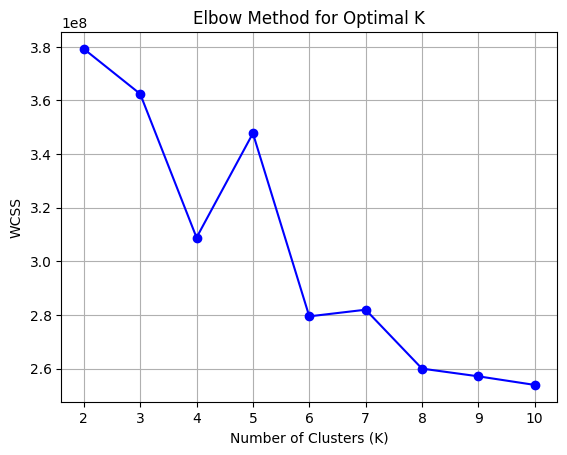

In [6]:
from pyspark.sql import SparkSession
from sklearn.datasets import fetch_20newsgroups
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("ElbowMethodExample").getOrCreate()

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

data = spark.createDataFrame([(str(i), text) for i, text in enumerate(newsgroups.data)], ["id", "text"])

tokenizer = Tokenizer(inputCol="text", outputCol="words")
count_vectorizer = CountVectorizer(inputCol="words", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="features")

pipeline = Pipeline(stages=[tokenizer, count_vectorizer, idf])
processed_data = pipeline.fit(data).transform(data)

wcss = []
k_values = range(2, 11)  # Adjust this range as needed
for k in k_values:
    kmeans = KMeans(k=k, featuresCol="features", seed=1)
    model = kmeans.fit(processed_data)
    wcss.append(model.summary.trainingCost)

plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')  # 'b' for blue color
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()
spark.stop()


You have to submit a notebook file:
• Should use Spark for K-means and agglomerative clustering.<br>
• Should contain elbow method plot for K-means.<br>
• Should contain dendrogram plot for Agglomerative clustering.<br>
• Optimal number of clusters for each methods.

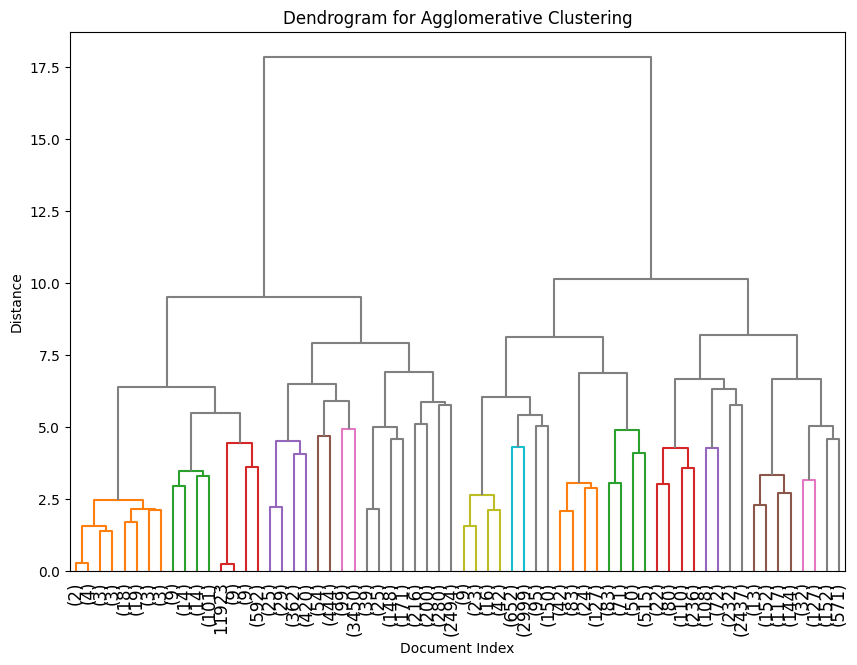

In [7]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(max_features=2000)  # Adjust max_features as needed
X = vectorizer.fit_transform(newsgroups.data)

# Perform Agglomerative clustering
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='ward')
clustering.fit(X.toarray())

# Plot the dendrogram with custom colors
Z = linkage(X.toarray(), 'ward')
plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='level', p=5, leaf_font_size=12, color_threshold=5.0, above_threshold_color='gray')  # Adjust parameters as needed
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Document Index')
plt.ylabel('Distance')
plt.show()

To determine the optimal number of clusters, you look for the longest vertical line that does not cross any extended horizontal lines (or where the distance at the horizontal line is the greatest). In this dendrogram, the longest vertical line without a crossing horizontal line appears to be the blue one. Cutting the dendrogram at this line's height would give you two clusters – as indicated by the two different colors (orange and green).

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.cluster import KMeans
import numpy as np
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

def embed_document(document):
    inputs = tokenizer(document, return_tensors='pt', truncation=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

document_embeddings = np.vstack([embed_document(doc) for doc in newsgroups.data])

kmeans = KMeans(n_clusters=20, random_state=42)
kmeans.fit(document_embeddings)
labels = kmeans.labels_


print(labels[:10])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
import gzip
import shutil

# Path to the compressed .gz file
gz_path = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz'

# Path for the decompressed .bin file
bin_path = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin'

# Decompress the .gz file
with gzip.open(gz_path, 'rb') as f_in:
    with open(bin_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Now you can load the Word2Vec model using the decompressed .bin file
# from gensim.models import KeyedVectors
# word2vec = KeyedVectors.load_word2vec_format(bin_path, binary=True)


In [ ]:
from gensim.models import KeyedVectors
from sklearn.cluster import KMeans
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')

# Load the 20 Newsgroups dataset
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Load a pretrained Word2Vec model
word2vec = KeyedVectors.load_word2vec_format(bin_path, binary=True)

# Function to embed a document using Word2Vec
def embed_document(document):
    words = word_tokenize(document.lower())
    embeddings = [word2vec[word] for word in words if word in word2vec]
    if len(embeddings) == 0:
        return np.zeros(word2vec.vector_size)
    return np.mean(embeddings, axis=0)

# Embed all documents
document_embeddings = np.vstack([embed_document(doc) for doc in newsgroups.data])

# Cluster the documents using K-means
kmeans = KMeans(n_clusters=20, random_state=42)
kmeans.fit(document_embeddings)
labels = kmeans.labels_

# Print the cluster assignments for the first few documents
print(labels[:10])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[12 13 15  7 11  7 11 12  9  6]


The output [12 13 15 7 11 7 11 12 9 6] represents the cluster assignments for the first ten documents in the 20 Newsgroups dataset after performing K-means clustering using Word2Vec embeddings. Each number corresponds to the cluster to which the respective document has been assigned.